In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from greedy_coverage_gpu import greedy, set_func
import random 

In [2]:
models_path = "models/"
user_cascades_path = "../data/weibo_preprocessed/users_cascades.pkl"
infos_cascades_path = "../data/weibo_preprocessed/infos_cascades.pkl"
features_influencers_path = "../data/weibo_features/features_influencers_all_200_noCas.pkl"
features_targets_path = "../data/weibo_features/features_targets_all_200_noCas.pkl"
edges_file = '../data/weibo/weibodata/graph_170w_1month.txt'

In [ ]:
u_to_userids = pd.read_csv("../data/weibo/weibodata/diffusion/uidlist.txt",header=None)
u_to_userids.columns = ['userid']
u_to_userids.index.name = 'uid'
# infos_cascades = pd.read_pickle(infos_cascades_path)

# infos_cascades_sample = infos_cascades.sample(n = 10000)
# del(infos_cascades)

In [4]:
model_df = torch.load(models_path + "df_all_200_noCas.pt")
model_2s = torch.load(models_path + "2s_all_200_noCas.pt")

## Tests on all weibo dataset

In [6]:
features_influencers = pd.read_pickle(features_influencers_path)
features_targets = pd.read_pickle(features_targets_path)
features_influencers = features_influencers.merge(u_to_userids.reset_index(), left_on=features_influencers.index, right_on = 'userid')
features_targets = features_targets.merge(u_to_userids.reset_index(), left_on=features_targets.index, right_on = 'userid')

In [9]:
d_fiu = defaultdict(lambda : False)
d_ftu = defaultdict(lambda : False)
for u in features_influencers.uid : d_fiu[u] = True
for v in features_targets.uid : d_ftu[v] = True

d_cascades = defaultdict(lambda : [])
for index, cascade in infos_cascades_sample.iterrows() : 
    u = cascade['User1']
    vs = cascade['users2']
    if d_fiu[u] : 
        for v in vs : 
            if d_ftu[v] : 
                d_cascades[u].append(v)

In [37]:
def feature(u,v) : 
    """
    u in d_cascades.keys() = inter(fiu, infos_cascades_sample)
    v in ftu
    """
    fu = features_influencers[features_influencers['uid'] == u].drop(columns = ['uid', 'userid'])
    fv = features_targets[features_targets['uid'] == v].drop(columns = ['uid', 'userid'])

    edge = 1 if v in d_edges[u] else 0 
    
    return torch.tensor(np.concatenate([fu, fv, edge], axis = None), dtype=torch.float).to('cuda')



In [47]:
d_DP_df = {u:[] for u in d_cascades.keys()}
d_DP_2s = {u:[] for u in d_cascades.keys()}

for u in d_cascades : 
    for v in d_cascades[u] : 
        d_DP_df[u].append(model_df(feature(u, v)).item())
        d_DP_2s[u].append(model_2s(feature(u, v)).item())


In [87]:
random_vs = features_targets.sample(n = 15).uid
d_DP_df_random = {u:[] for u in d_cascades.keys()}
d_DP_2s_random = {u:[] for u in d_cascades.keys()}

for u in d_cascades : 
    for v in random_vs : 
        d_DP_df_random[u].append(model_df(feature(u, v)).item())
        d_DP_2s_random[u].append(model_2s(feature(u, v)).item())


In [94]:
d_mean = {u:[] for u in d_cascades.keys()}
for u in d_cascades : 
    d_mean[u] = [np.mean(d_DP_df[u]), np.mean(d_DP_2s[u]), np.mean(d_DP_df_random[u]), np.mean(d_DP_2s_random[u]),]
df_mean = pd.DataFrame.from_dict(d_mean, orient='index', columns=['DF model \nv in cascade', '2S model \nv in cascade', 'DF model \nrandom v', '2S model \nrandom v'])


Text(0.5, 0.98, 'Difference of predicted DPs when targets are in the cascade or not')

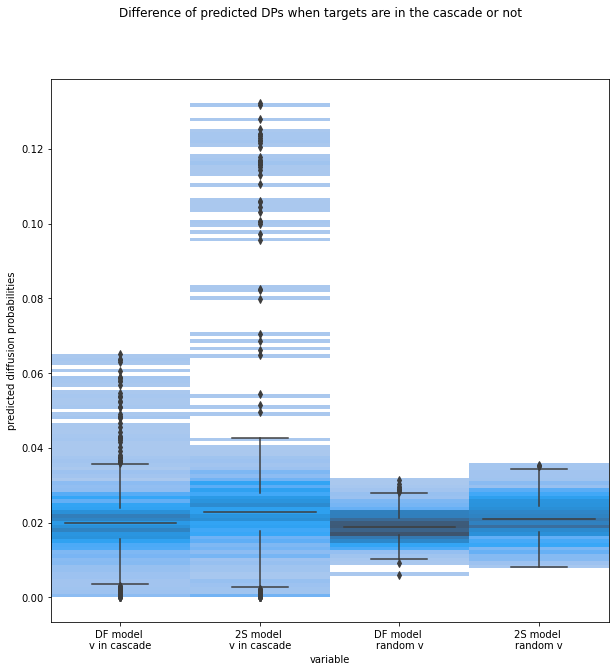

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="variable", y="value", data=pd.melt(df_mean), ax = ax)
sns.histplot(x="variable", y="value", data=pd.melt(df_mean),ax = ax)
ax.set_ylabel('predicted diffusion probabilities')
fig.suptitle('Difference of predicted DPs when targets are in the cascade or not')

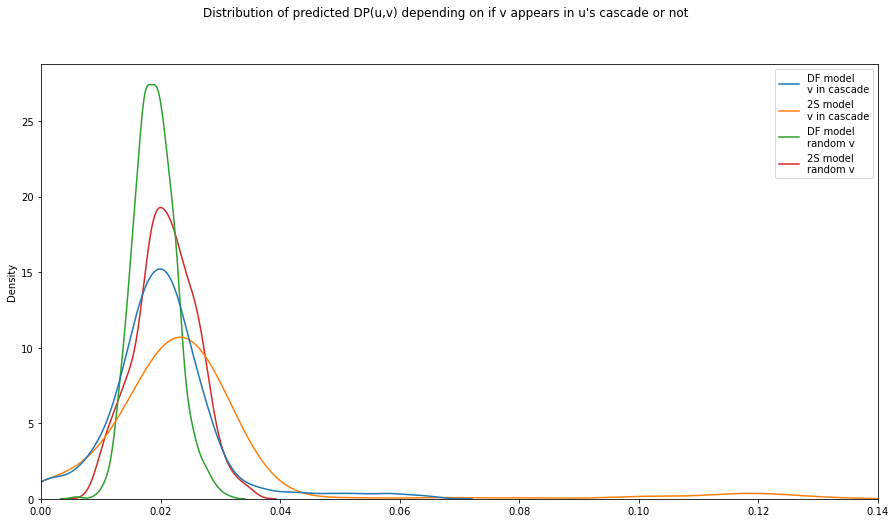

In [101]:
fig, ax = plt.subplots(figsize = (15,8))
sns.kdeplot(data=df_mean, ax = ax)
ax.set_xlim(0,0.14)
fig.suptitle("Distribution of predicted DP(u,v) depending on if v appears in u's cascade or not")
plt.show()

In [ ]:


influencers = df_labels.groupby('u').count().index
targets = df_labels.groupby('v').count().index

random_pairs = random.sample([k for k in zip(influencers, targets) if not d_pos[k]], 1000)
positive_pairs = list(df_labels.sample(n=1000)[['u','v']].itertuples(index=False, name=None))


In [ ]:
results = []
for k in range(1000) :
    u,v = positive_pairs[k]
    dp_pos_df = model_df(feature_twitter(u,v)).item()
    dp_pos_2s = model_2s(feature_twitter(u,v)).item()
    w,t = random_pairs[k]
    dp_rand_df = model_df(feature_twitter(w,t)).item()
    dp_rand_2s = model_2s(feature_twitter(w,t)).item()

    results.append([dp_pos_df, dp_pos_2s, dp_rand_df, dp_rand_2s])


In [ ]:
df_results = pd.DataFrame(results)
df_results.columns = ['df model \nv in cascade', '2s model \nv in cascade', 'df model \nv not in cascade', '2s model \nv not in cascade']

## Tests on sparse instances

In [22]:
instance_path = "../decision_focused_learning_gpu/instances_weibo/06-16-10K_5_0pI_noCas/"
# instance_path = "../data/twitter_preprocessed/XY_5K_10/"
N_INSTANCES, N_INFLUENCERS, N_TARGETS, N_FEATURES = 5, 1000, 1000, 19

X = np.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS, N_FEATURES))
Y = np.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS))
# Yemb = np.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS))

for instance in range(N_INSTANCES) :
    XY = np.load(instance_path + f"{instance}.npz")['arr_0']
    X[instance] = XY[:,:,:-2]
    Y[instance] = XY[:,:,-2]
    # Yemb[instance] = XY[:,:,-1]

def transform_Y(Y) : 
    Yc = np.copy(Y)
    #return np.minimum(100 * Y_train, np.ones((N_TRAIN, N_INFLUENCERS, N_TARGETS)))
    t1 = np.quantile(Y[Y>0], 0.2) # weak probability
    t2 = np.quantile(Y[Y>0], 0.5) # medium probability
    t3 = np.quantile(Y[Y>0], 0.8) # high probability
    Y[Yc>0] = 0.1
    Y[Yc>t1] = 0.2
    Y[Yc>t2] = 0.5
    Y[Yc>t3] = 1.
    return Y  

softmax = lambda x : np.exp(x)/np.sum(np.exp(x))

def transform_Yemb(Y) :
    # Y.apply_(lambda x : np.exp(a*x))
    # Y.apply_(lambda x : 1/(1+np.exp(-a*x)))
    for instance in range(Y.shape[0]) : 
        Y[instance] = np.apply_along_axis(lambda x:x-abs(max(x)), 1, Y[instance]) 
        Y[instance] = np.apply_along_axis(softmax, 1, Y[instance])
        Y[instance] = np.around(Y[instance],3)
        Y[instance] = np.abs(Y[instance])/np.max(Y[instance])
    return Y
    
Y = transform_Y(Y)
# Yemb = transform_Yemb(Yemb)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()
# Yemb = torch.from_numpy(Yemb).float()


In [23]:
model_df = torch.load(models_path + "df_all_200_noCas.pt").to('cpu')
model_2s = torch.load(models_path + "2s_all_200_noCas.pt").to('cpu')

In [24]:
def compute_dni(seeds, Y) : 
    """
    estimates the number of Different Nodes Infected given a seed set and a DATA-BASED label. 
        If a data-based label of (u,v) is positive, it means that v appears in at least one cascade of u
    for each column(target) if one of the labels is >0 then it appears in a cascade provoqued by one of the seeds
    """
    return (Y[seeds,:].sum(dim=0) > 0).sum().item() 

w = torch.ones(N_INFLUENCERS)

def eval_grd(x, y, net, k,w,ydb = None) :
    """
    Executes greedy algorithm on the given data.
    """
    predY = net(x).view_as(y)
    _, seeds = greedy(k, predY, w)
    exp = set_func(seeds, y, w)
    if ydb is not None :
        dni = compute_dni(seeds, ydb)
    else :
        dni = compute_dni(seeds, y)
    return float(exp), dni

def eval_rnd(k, y,w, ydb = None) :
    """
    Executes random algorithm on the given data.
    """
    exps, dnis = [], []
    for _ in range(5):
        seeds = random.sample(range(y.shape[1]), k)
        exps.append(float(set_func(seeds, y,w)))
            
        if ydb is not None :
            dni = compute_dni(seeds, ydb)
        else :
            dni = compute_dni(seeds, y)
        dnis.append(dni)
    return np.mean(exps), np.mean(dnis)


def eval_oracle(k, y, w, ydb = None) :
    """
    Executes oracle algorithm on the given data.
    """
    exp, oracle_seeds = greedy(k, y, w)
    if ydb is not None :
        dni = compute_dni(oracle_seeds, ydb)
    else :
        dni = compute_dni(oracle_seeds, y)
    return float(exp), dni

def eval_grd_all(X,Y, net, k, w) : 
    exps, dnis = [], []
    for i in range(X.shape[0]) :
        exp, dni = eval_grd(X[i], Y[i], net, k, w)
        exps.append(exp)
        dnis.append(dni)
    return [np.mean(exps), np.std(exps), np.mean(dnis), np.std(dnis)]

def eval_rnd_all(k, Y, w) : 
    exps, dnis = [], []
    for i in range(Y.shape[0]) :
        exp, dni = eval_rnd(k, Y[i], w)
        exps.append(exp)
        dnis.append(dni)
    return [np.mean(exps), np.std(exps), np.mean(dnis), np.std(dnis)]

def eval_oracle_all(k, Y, w) : 
    exps, dnis = [], []
    for i in range(X.shape[0]) :
        exp, dni = eval_oracle(k, Y[i], w)
        exps.append(exp)
        dnis.append(dni)
    return [np.mean(exps), np.std(exps), np.mean(dnis), np.std(dnis)]


In [25]:
Ks = list(range(0, N_INFLUENCERS//5 , N_INFLUENCERS//100))
d_results = {k:[] for k in Ks}

#add the 2r feature in X
if X.shape[3] == 19 : X = torch.cat((X[:,:,:,:6], torch.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS,2)), X[:,:,:,6:15], torch.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS,1)),  X[:,:,:,15:]), dim=3)
# x,y,ydb = X[0], Yemb[0], Y[0]
x,y = X[0], Y[0]
w = torch.ones(N_INFLUENCERS)


In [26]:

for k in Ks :
    print(k)
    d_results[k] += list(eval_grd(x, y, model_df, k, w,)) # ydb = ydb))
    d_results[k] += list(eval_grd(x, y, model_2s, k, w))
    d_results[k] += list(eval_oracle(k, y, w))
    d_results[k] += list(eval_rnd(k, y, w))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [14]:
df_results_zero = pd.DataFrame.from_dict(d_results, orient='index', columns=['exp_df', 'dni_df', 'exp_2s', 'dni_2s','exp_oracle', 'dni_oracle', 'exp_rnd', 'dni_rnd'])
df_results_zero

,exp_df,dni_df,exp_2s,dni_2s,exp_oracle,dni_oracle,exp_rnd,dni_rnd
0,0.000000,0,0.000000,0,0.000000,0,0.000,0.0
10,0.800000,7,0.800000,7,6.300000,18,0.180,0.8
20,1.500000,13,2.000000,14,11.300000,28,1.220,3.8
30,2.600000,16,2.100000,15,16.299999,38,1.920,6.0
40,3.000000,18,3.800000,19,21.299999,48,1.520,4.2
50,3.500000,19,3.700000,20,26.299999,58,3.140,9.2
60,4.700000,22,4.900001,23,31.299999,68,4.920,15.2
70,5.100000,24,5.400001,26,36.299999,78,3.420,11.8
80,6.000000,28,5.800000,30,41.299999,88,5.880,20.2
90,6.800000,32,6.700000,33,46.299999,98,6.360,18.6


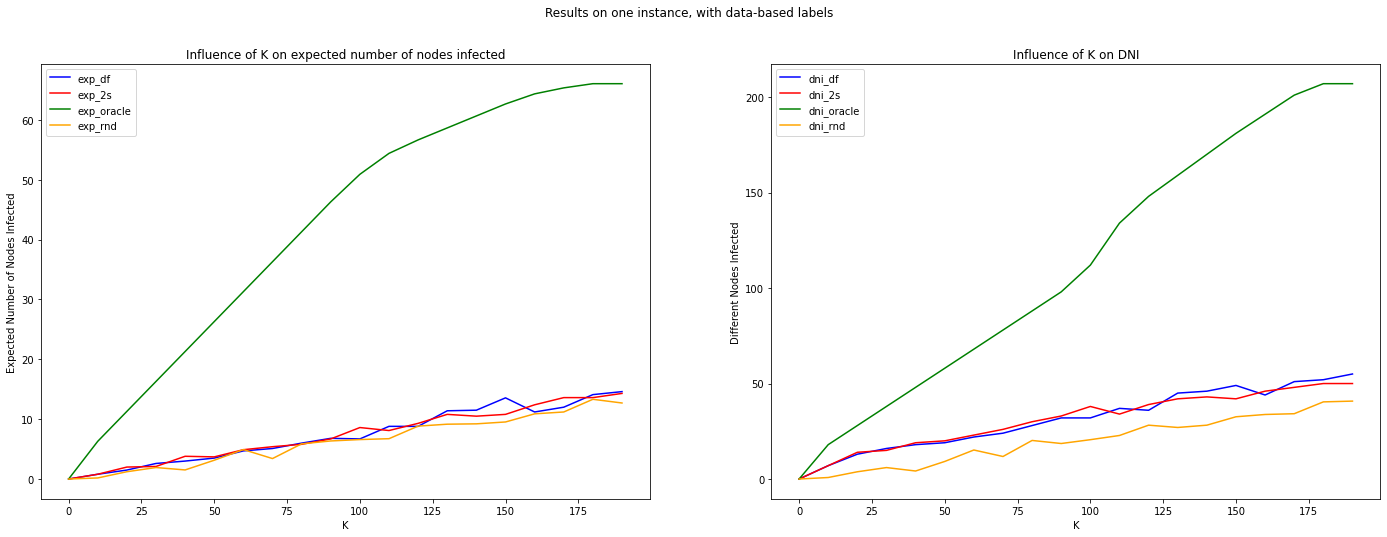

In [15]:
def plot_kdependence(df_results, title=""):
    """
    d_results : exp_df, dni_df, exp_2s, dni_2s, exp_oracle, dni_oracle, exp_rnd, dni_rnd
    """
    fig,ax = plt.subplots(1,2,figsize=(24,8))
    sns.lineplot(data=df_results, x=df_results.index, y='exp_df', label='exp_df', color='blue', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_2s', label='exp_2s', color='red', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_oracle', label='exp_oracle', color='green', ax=ax[0])
    sns.lineplot(data=df_results, x=df_results.index, y='exp_rnd', label='exp_rnd', color='orange', ax=ax[0])
    ax[0].set_title('Influence of K on expected number of nodes infected')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Expected Number of Nodes Infected')
    ax[0].legend()

    sns.lineplot(data=df_results, x=df_results.index, y='dni_df', label='dni_df', color='blue', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_2s', label='dni_2s', color='red', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_oracle', label='dni_oracle', color='green', ax=ax[1])
    sns.lineplot(data=df_results, x=df_results.index, y='dni_rnd', label='dni_rnd', color='orange', ax=ax[1])
    ax[1].set_title('Influence of K on DNI')
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('Different Nodes Infected')
    ax[1].legend()

    fig.suptitle(title)
    plt.show()

plot_kdependence(df_results_zero, title='Results on one instance, with data-based labels')

In [9]:
Ks = list(range(0, N_INFLUENCERS//10 , 50)) + list(range(N_INFLUENCERS//10, N_INFLUENCERS, 100))
d_results_all = {k:[] for k in Ks}

#add the 2r feature in X
if X.shape[3] == 21 : X = torch.cat((X[:,:,:,:6], torch.zeros((N_INSTANCES, N_INFLUENCERS, N_TARGETS,1)), X[:,:,:,6:]), dim=3)
w = torch.ones(N_INFLUENCERS)

for k in Ks:
    print(k)
    d_results_all[k] += list(eval_grd_all(X, Y, model_df, k, w))
    d_results_all[k] += list(eval_grd_all(X, Y, model_2s, k, w))
    d_results_all[k] += list(eval_oracle_all(k, Y, w))
    d_results_all[k] += list(eval_rnd_all(k, Y, w))


0


KeyboardInterrupt: 

In [ ]:
df_results_all = pd.DataFrame.from_dict(d_results_all, orient='index', columns=['exp_df', 'exp_df_std', 'dni_df', 'dni_df_std', 'exp_2s', 'exp_2s_std', 'dni_2s', 'dni_2s_std', 'exp_oracle', 'exp_oracle_std', 'dni_oracle', 'dni_oracle_std', 'exp_rnd', 'exp_rnd_std', 'dni_rnd', 'dni_rnd_std'])
df_results_all

,exp_df,exp_df_std,dni_df,dni_df_std,exp_2s,exp_2s_std,dni_2s,dni_2s_std,exp_oracle,exp_oracle_std,dni_oracle,dni_oracle_std,exp_rnd,exp_rnd_std,dni_rnd,dni_rnd_std
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
50,1.330862,0.311377,101.5,18.591665,1.423669,0.204514,108.7,20.484384,10.346307,0.579331,73.8,3.400000,1.313444,0.275985,20.40,3.600000
100,2.674584,0.471083,136.1,22.531977,2.948529,0.424450,143.6,21.129127,15.085268,0.706312,137.8,6.431174,2.706387,0.351992,43.12,5.107015
200,5.608338,0.850464,191.0,26.638318,6.001621,0.648079,183.0,23.820160,22.849398,1.118746,273.5,10.547512,5.129269,0.477207,83.12,4.815143
300,8.264626,1.201487,231.3,27.575533,8.360354,0.487415,212.9,25.181144,25.392632,1.547352,417.9,21.552030,7.465872,0.697063,126.24,12.626892
400,10.974909,1.403531,267.4,26.473383,10.960338,0.871742,244.5,26.428205,25.392632,1.547352,417.9,21.552030,10.271071,0.726517,172.38,13.199227
500,13.494248,1.200465,296.1,23.509360,13.207111,0.796998,273.0,25.961510,25.392632,1.547352,417.9,21.552030,12.591386,0.718189,209.16,10.819908
600,15.951050,1.127076,324.1,24.345225,16.044331,0.964526,321.0,24.592682,25.392632,1.547352,417.9,21.552030,15.290234,1.059396,251.58,13.951473
700,18.333131,1.325408,351.8,24.919069,18.381268,1.093728,345.9,23.330024,25.392632,1.547352,417.9,21.552030,17.740706,0.979122,296.20,17.326511
800,21.131881,1.294713,377.9,25.228753,20.668225,1.480292,368.9,21.426386,25.392632,1.547352,417.9,21.552030,20.288427,1.210306,338.58,21.346747


In [ ]:
eval_grd_all(X, Y, model_df, 20, w)

[0.3310895711183548, 0.032245104521701366, 321.55, 52.469491135325484]

NameError: name 'df_results' is not defined

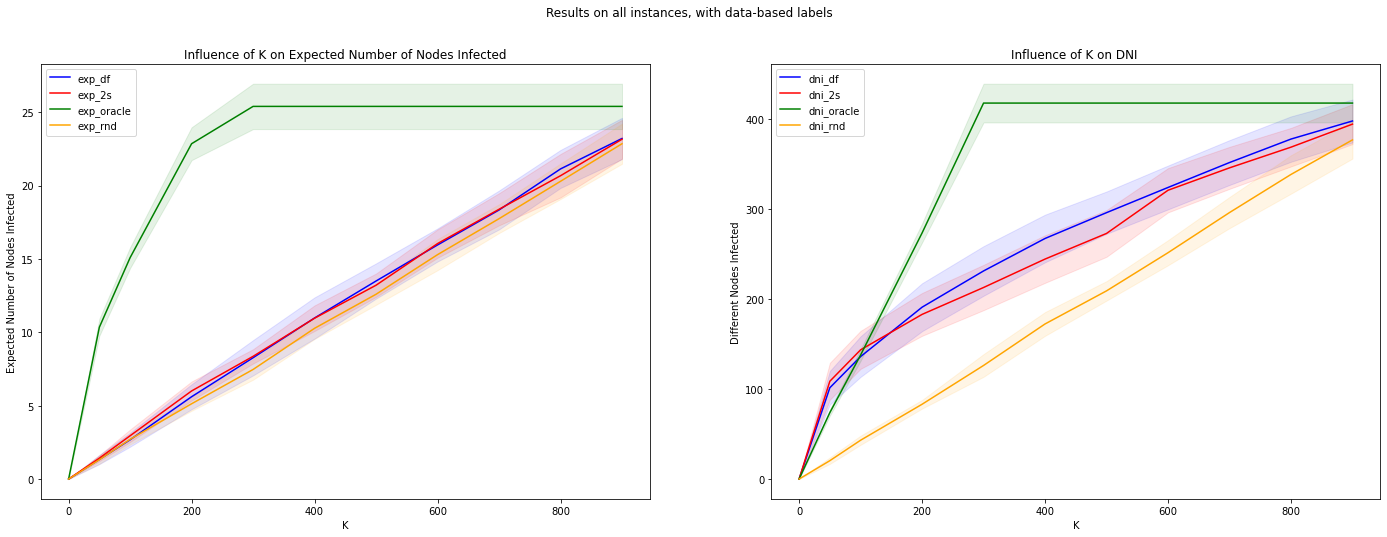

In [ ]:
df_results_all['exp_df_lower'] = df_results_all['exp_df'] - df_results_all['exp_df_std']
df_results_all['exp_df_upper'] = df_results_all['exp_df'] + df_results_all['exp_df_std']
df_results_all['exp_2s_lower'] = df_results_all['exp_2s'] - df_results_all['exp_2s_std']
df_results_all['exp_2s_upper'] = df_results_all['exp_2s'] + df_results_all['exp_2s_std']
df_results_all['exp_oracle_lower'] = df_results_all['exp_oracle'] - df_results_all['exp_oracle_std']
df_results_all['exp_oracle_upper'] = df_results_all['exp_oracle'] + df_results_all['exp_oracle_std']
df_results_all['exp_rnd_lower'] = df_results_all['exp_rnd'] - df_results_all['exp_rnd_std']
df_results_all['exp_rnd_upper'] = df_results_all['exp_rnd'] + df_results_all['exp_rnd_std']

df_results_all['dni_df_lower'] = df_results_all['dni_df'] - df_results_all['dni_df_std']
df_results_all['dni_df_upper'] = df_results_all['dni_df'] + df_results_all['dni_df_std']
df_results_all['dni_2s_lower'] = df_results_all['dni_2s'] - df_results_all['dni_2s_std']
df_results_all['dni_2s_upper'] = df_results_all['dni_2s'] + df_results_all['dni_2s_std']
df_results_all['dni_oracle_lower'] = df_results_all['dni_oracle'] - df_results_all['dni_oracle_std']
df_results_all['dni_oracle_upper'] = df_results_all['dni_oracle'] + df_results_all['dni_oracle_std']
df_results_all['dni_rnd_lower'] = df_results_all['dni_rnd'] - df_results_all['dni_rnd_std']
df_results_all['dni_rnd_upper'] = df_results_all['dni_rnd'] + df_results_all['dni_rnd_std']

def plot_kdependence_all(df_results_all, title=""):
    """
    d_results : exp_df, dni_df, exp_2s, dni_2s, exp_oracle, dni_oracle, exp_rnd, dni_rnd
    """
    fig,ax = plt.subplots(1,2,figsize=(24,8))
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_df', label='exp_df', color='blue', ax=ax[0])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_2s', label='exp_2s', color='red', ax=ax[0])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_oracle', label='exp_oracle', color='green', ax=ax[0])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='exp_rnd', label='exp_rnd', color='orange', ax=ax[0])
    
    ax[0].fill_between(df_results_all.index, df_results_all['exp_df_lower'], df_results_all['exp_df_upper'], color='blue', alpha=0.1)
    ax[0].fill_between(df_results_all.index, df_results_all['exp_2s_lower'], df_results_all['exp_2s_upper'], color='red', alpha=0.1)
    ax[0].fill_between(df_results_all.index, df_results_all['exp_oracle_lower'], df_results_all['exp_oracle_upper'], color='green', alpha=0.1)
    ax[0].fill_between(df_results_all.index, df_results_all['exp_rnd_lower'], df_results_all['exp_rnd_upper'], color='orange', alpha=0.1)

    ax[0].set_title('Influence of K on Expected Number of Nodes Infected')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Expected Number of Nodes Infected')
    ax[0].legend()

    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_df', label='dni_df', color='blue', ax=ax[1])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_2s', label='dni_2s', color='red', ax=ax[1])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_oracle', label='dni_oracle', color='green', ax=ax[1])
    sns.lineplot(data=df_results_all, x=df_results_all.index, y='dni_rnd', label='dni_rnd', color='orange', ax=ax[1])

    ax[1].fill_between(df_results_all.index, df_results_all['dni_df_lower'], df_results_all['dni_df_upper'], color='blue', alpha=0.1)
    ax[1].fill_between(df_results_all.index, df_results_all['dni_2s_lower'], df_results_all['dni_2s_upper'], color='red', alpha=0.1)
    ax[1].fill_between(df_results_all.index, df_results_all['dni_oracle_lower'], df_results_all['dni_oracle_upper'], color='green', alpha=0.1)
    ax[1].fill_between(df_results_all.index, df_results_all['dni_rnd_lower'], df_results_all['dni_rnd_upper'], color='orange', alpha=0.1)

    ax[1].set_title('Influence of K on DNI ')
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('Different Nodes Infected')
    ax[1].legend()

    fig.suptitle(title)
    plt.show()

plot_kdependence_all(df_results_all, title="Results on all instances, with data-based labels")

Exp-train
Exp-test
DNI-train
DNI-test

df - 2s - rnd - grd 

In [23]:
n_iter = 15
with open('results/perfs_train_test_2.txt', 'r') as file : 
    d = {"Exp-train df" : np.zeros((n_iter,5)), "Exp-test df" : np.zeros((n_iter,5)), "Exp-train 2s" : np.zeros((n_iter,5)), "Exp-test 2s" : np.zeros((n_iter,5)), 
         "Exp-train rnd" : np.zeros((n_iter,5)), "Exp-test rnd" : np.zeros((n_iter,5)), "Exp-train grd" : np.zeros((n_iter,5)), "Exp-test grd" : np.zeros((n_iter,5)),
         "DNI-train df" : np.zeros((n_iter,5)), "DNI-test df" : np.zeros((n_iter,5)), "DNI-train 2s" : np.zeros((n_iter,5)), "DNI-test 2s" : np.zeros((n_iter,5)),
         "DNI-train rnd" : np.zeros((n_iter,5)), "DNI-test rnd" : np.zeros((n_iter,5)), "DNI-train grd" : np.zeros((n_iter,5)), "DNI-test grd" : np.zeros((n_iter,5))}
    n = -1
    for line in file : 
        line = line.split(',')
        if line[0] == 'Exp-train df' : 
            n += 1
        if line[0] in d.keys() : 
            d[line[0]][n,:] = [float(x) for x in line[1:]]
    

In [24]:
d_mean, d_std = {}, {}
for k in d.keys() : 
    d_mean[k] = np.mean(d[k], axis=0)
    d_std[k] = np.std(d[k], axis=0)
df_mean = pd.DataFrame.from_dict(d_mean, orient='index')
df_std = pd.DataFrame.from_dict(d_std, orient='index')

In [25]:
print(df_mean.to_markdown())
print(df_std.to_markdown())

|               |        0 |        1 |       2 |       3 |       4 |
|:--------------|---------:|---------:|--------:|--------:|--------:|
| Exp-train df  |  90.8381 | 142.543  | 239.879 | 320.397 | 386.949 |
| Exp-test df   |  88.3989 | 139.789  | 236.278 | 318.384 | 385.277 |
| Exp-train 2s  |  44.7071 |  80.9745 | 165.555 | 261.966 | 368.849 |
| Exp-test 2s   |  44.7091 |  80.6233 | 162.294 | 261.044 | 368.604 |
| Exp-train rnd |  39.15   |  73.7773 | 166.406 | 266.702 | 373.488 |
| Exp-test rnd  |  37.7567 |  76.7452 | 163.13  | 265.323 | 372.779 |
| Exp-train grd | 119.244  | 191.659  | 319.478 | 412.02  | 465.548 |
| Exp-test grd  | 119.269  | 191.068  | 318.398 | 411.569 | 465.675 |
| DNI-train df  | 326.387  | 369.221  | 408.363 | 427.65  | 440.517 |
| DNI-test df   | 319.617  | 359.967  | 403.433 | 424.733 | 437.95  |
| DNI-train 2s  | 111.692  | 176.975  | 293.083 | 378.175 | 440.358 |
| DNI-test 2s   | 123.167  | 181.717  | 301.9   | 377.233 | 441.217 |
| DNI-train rnd |  8